# Behavioral Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

# Imports

In [82]:
import pandas as pd; import seaborn as sb; import warnings; import scipy; import re; 
import os; from analysis_helpers import *; import itertools; from scipy import stats
import random; import pandas as pd; import numpy as np; from sklearn import datasets, linear_model; 
from sklearn.linear_model import LinearRegression; import statsmodels.api as sm
from scipy import stats; from itertools import groupby; from operator import itemgetter; import pingouin
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [224]:
data = pd.read_csv('../parsed_data/FULL_DATA.csv')

# Data Organize

In [225]:
# Add trial numbers
data['Trial'] = np.nan
data.loc[data['Trial Type']=='Memory','Trial']       = list(range(0,40))*len(data['UniqueID'].unique())*8
data.loc[data['Trial Type']=='Presentation','Trial'] = list(range(0,10))*len(data['UniqueID'].unique())*8

### Exp1: add cued category from previous presentation to memory trials 

In [226]:
for s in data['UniqueID'].unique():
    for r in data['Run'].unique():
        data.loc[(data['Run']==r) 
                 & (data['UniqueID']==s) 
                 & (data['Trial Type']=='Memory'), 'Last Cued'] = data[(data['Run']==r) & (data['UniqueID']==s) & (data['Trial Type']=='Presentation') & (data['Trial']==9)]['Cued Category'].item()

### Re-Label Novel images by Cued or Uncued category

In [227]:
data = add_nov_label(data, column_name = 'Last Cued')

### Working version of the data with all Novel images together (not split by cued or uncued)

In [89]:
data_nov = data.replace(to_replace=['Nov_Cued','Nov_Un'], value='Novel')

# Stats

Below are all of the statistical tests done on the behavioral data, roughly in the order they appear in the paper

### Reaction Time Stats (Cued vs. Uncued side)

In [94]:
# compare average attention probe reaction times (valid versus invalid)

data_gr = data.groupby(['UniqueID','Cue Validity', 'Experiment', 'Group'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
    
        print('exp : '+ experiment + ', group : '+str(group))
        print(scipy.stats.ttest_rel(data_gr[(data_gr['Cue Validity']==1) 
                                            & (data_gr['Experiment']== experiment) 
                                            & (data_gr['Group']== group)]['Attention Reaction Time (s)'], 

                                    data_gr[(data_gr['Cue Validity']==0) 
                                            & (data_gr['Experiment']== experiment) 
                                            & (data_gr['Group']== group)]['Attention Reaction Time (s)']))

        print()
        
#         print(cohen_d(list(data_gr[(data_gr['Cue Validity']==1) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)']),
#                       list(data_gr[(data_gr['Cue Validity']==0) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)'])))

        print()

exp : /sustain, group : 1
Ttest_relResult(statistic=-2.7265644956566235, pvalue=0.01074400669470906)


exp : /sustain, group : 2
Ttest_relResult(statistic=0.5789521304269601, pvalue=0.5670915482025658)


exp : /variabl, group : 1
Ttest_relResult(statistic=-0.5318760704045474, pvalue=0.5988631588943483)


exp : /variabl, group : 2
Ttest_relResult(statistic=-0.3488857824614143, pvalue=0.7308212078074103)




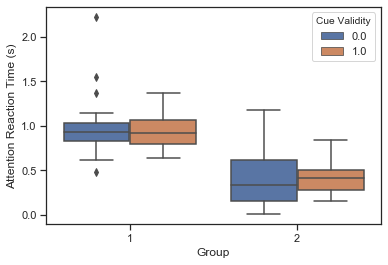

In [116]:
sb.boxplot(data=data_gr[data_gr['Experiment']=='/variabl'], x='Group', y='Attention Reaction Time (s)', hue='Cue Validity')
                                             

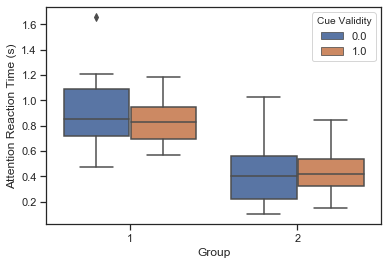

In [117]:
sb.boxplot(data=data_gr[data_gr['Experiment']=='/sustain'], x='Group', y='Attention Reaction Time (s)', hue='Cue Validity')                                        

# Calculate Differences

In [119]:
# diffs = {'Experiment_1':[], 'Experiment_2':[]}

# for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
#     for s in d['Subject'].unique():
#         cued   = d[(d['Subject']==s)&(d['Cue Validity']==0)]['Attention Reaction Time (s)'].mean()
#         uncued = d[(d['Subject']==s)&(d['Cue Validity']==1)]['Attention Reaction Time (s)'].mean()

#         diffs[label].append(cued - uncued)

# print('RT Diff Comparison')
# print(scipy.stats.ttest_ind(diffs['Experiment_1'], diffs['Experiment_2']))
# print(cohen_d(diffs['Experiment_1'], diffs['Experiment_2']))

### Compare Fully Attended images to all other images

In [192]:
# compare average ratings for fully attended images to all other image types 

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
    
        Fulls  = []
        Others = []
        
        for s in data[(data['Experiment']==experiment) &
                         (data['Group']==group)]['UniqueID'].unique():
        
            Fulls.append(data[(data['UniqueID']==s)&(data['Attention Level']=='Full') & (data['Experiment']==experiment) &
                         (data['Group']==group)]['Familiarity Rating'].mean())
            Others.append(data[(data['UniqueID']==s)&(data['Attention Level']!='Full') & (data['Experiment']==experiment) &
                         (data['Group']==group)]['Familiarity Rating'].mean())

        print()
        print('experiment : '+experiment + ', group : '+str(group))
        print(scipy.stats.ttest_rel(Fulls, Others))
        print()
        


experiment : /sustain, group : 1
Ttest_relResult(statistic=9.396112809093742, pvalue=2.6596964490466333e-10)


experiment : /sustain, group : 2
Ttest_relResult(statistic=9.4324626878534, pvalue=2.44237380624864e-10)


experiment : /variabl, group : 1
Ttest_relResult(statistic=9.269878100958035, pvalue=3.580794406292164e-10)


experiment : /variabl, group : 2
Ttest_relResult(statistic=8.38699196124214, pvalue=5.575698282277977e-08)



### Face versus Scene

In [193]:
# compare ratings for fully attended scenes with ratings for fully attended faves

f_p = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level', 'Category'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
            print()
        
            print('experiment : '+experiment+', Group : '+str(group))
        
            print(scipy.stats.ttest_rel(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full') 
                                            & (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating'], 
                                        
                                        f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full') 
                                            & (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating']))
            
            print ()
    
            
#             print(cohen_d(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating'], 
#                                 f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating']))
#             print()


          


experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.5990321530636935, pvalue=4.809466356149415e-06)


experiment : /sustain, Group : 2
Ttest_relResult(statistic=5.188664026632938, pvalue=1.5014227199706535e-05)


experiment : /variabl, Group : 1
Ttest_relResult(statistic=6.014667685209905, pvalue=1.5299794276127339e-06)


experiment : /variabl, Group : 2
Ttest_relResult(statistic=5.575988694452312, pvalue=1.8565342348610204e-05)



### Attended Category versus Unattended

In [194]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        Cats  = []
        Nones = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
    
            Cats.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Category']) & (d['Experiment']==experiment) &
                             (d['Group']==group))]['Familiarity Rating'].mean())
            Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())

                
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(Cats, Nones))
        #print(cohen_d(Cats, Nones))
        print()

experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.1684995922238475, pvalue=1.5879652460430842e-05)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=4.893056610511507, pvalue=3.414597092562701e-05)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=1.1502277954582985, pvalue=0.25944705754001357)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=-1.4235573907651509, pvalue=0.1699887871532115)



### Attended Side vs Unattended

In [195]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        Sides  = []
        Nones = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
        
            Sides.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Side'])) & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())
            Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean())

        print(scipy.stats.ttest_rel(Sides, Nones))
        print()

Ttest_relResult(statistic=3.7879181404481477, pvalue=0.0007093128554569094)

Ttest_relResult(statistic=2.276573635603415, pvalue=0.030374011887027853)

Ttest_relResult(statistic=1.151911126217005, pvalue=0.25876576664038065)

Ttest_relResult(statistic=2.334208754511848, pvalue=0.030127421790291382)



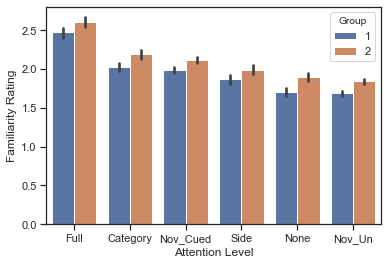

In [196]:
# sustained attention experiment

sb.barplot(data=data[data['Experiment']=='/sustain'], x='Attention Level', y='Familiarity Rating', hue='Group',
          order=['Full','Category','Nov_Cued','Side','None','Nov_Un'])

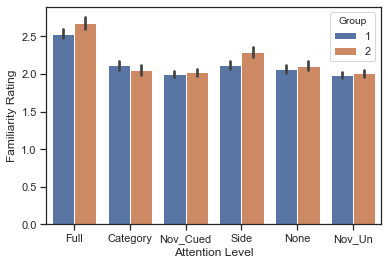

In [197]:
# variable attention experiment

sb.barplot(data=data[data['Experiment']=='/variabl'], x='Attention Level', y='Familiarity Rating', hue='Group',
          order=['Full','Category','Nov_Cued','Side','None','Nov_Un'])

### Cued versus Uncued Novel images

In [198]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
    
        a = d[(d['Attention Level']=='Nov_Cued') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating']
        b = d[(d['Attention Level']=='Nov_Un') & (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating']
    
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(a, b))
    #print(cohen_d(a, b))
        print()
    

experiment : /sustain, Group : 1
Ttest_relResult(statistic=5.644488500528172, pvalue=4.24125222302965e-06)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=4.371049508578633, pvalue=0.0001449220357272557)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=0.22263341929217775, pvalue=0.8253814425522065)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=0.399151620703357, pvalue=0.6940115333399981)



### Feature boost versus feature bias boost

In [199]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        cat_no   = []
        nov_diff = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():

            cat = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full']))& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            no = d[(d['UniqueID']==s) &(d['Attention Level']=='None')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            nov_c = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Cued')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()
            nov_u = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Un')& (d['Experiment']==experiment) &
                             (d['Group']==group)]['Familiarity Rating'].mean()

            cat_no.append(cat - no)
            nov_diff.append(nov_c - nov_u)


        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_no, nov_diff))
        #print(cohen_d(cat_no, nov_diff))
        print()


experiment : /sustain, Group : 1
Ttest_relResult(statistic=4.887164874941902, pvalue=3.470955222514344e-05)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=6.1242380609704075, pvalue=1.1333753180006843e-06)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=4.678914433449425, pvalue=6.187418450411306e-05)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=4.313594052071855, pvalue=0.0003379597732379957)



### Feature boost versus Location boost

In [204]:
# SHOWN BELOW:

# mean(Cat & Full) - mean(None)
# versus
# mean(Side & Full) - mean(None)

# -------------------------------
# NOT YET REPLICATED IN NEW DATA:

# Experiment 1: ( (mean(Cat & Full) - mean(None))  -    (mean(Side & Full) - mean(None)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(None))   -    (mean(Side & Full) - mean(None)) )    

In [201]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()


full = {}

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + str(group)
        
        cat_nov  = []
        side_nov = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():
            
            side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side','Full']) & (d['Experiment']==experiment) &
                 (d['Group']==group))]['Familiarity Rating'].mean()
            cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full'])) & (d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None') & (d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()

            cat_nov.append(cat - nov)
            side_nov.append(side - nov)
            

        print()
        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_nov, side_nov))
        print()



experiment : /sustain, Group : 1
Ttest_relResult(statistic=2.014132935151354, pvalue=0.053354679535675666)


experiment : /sustain, Group : 2
Ttest_relResult(statistic=2.5429220600219917, pvalue=0.01658870491611)


experiment : /variabl, Group : 1
Ttest_relResult(statistic=-0.048775036082222424, pvalue=0.9614329535003077)


experiment : /variabl, Group : 2
Ttest_relResult(statistic=-2.8851607654867504, pvalue=0.009152019828314708)



### Fully Attended versus Side Attended boost

In [207]:
d = data.groupby(['UniqueID', 'Experiment', 'Group', 'Attention Level'], as_index=False).mean()


full = {}

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + str(group)
        
        cat_nov  = []
        side_nov = []
        
        for s in d[(d['Experiment']==experiment) &
                 (d['Group']==group)]['UniqueID'].unique():

            side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side']))&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Full']))&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()
            nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None')&(d['Experiment']==experiment) &
                 (d['Group']==group)]['Familiarity Rating'].mean()

            cat_nov.append(cat - nov)
            side_nov.append(side - nov)


        print('experiment : '+experiment+', Group : '+str(group))
        print(scipy.stats.ttest_rel(cat_nov, side_nov))
        # print(cohen_d(cat_nov, side_nov))
        print()

            

experiment : /sustain, Group : 1
Ttest_relResult(statistic=6.614537828573972, pvalue=2.996178170829052e-07)

experiment : /sustain, Group : 2
Ttest_relResult(statistic=6.709530304671066, pvalue=2.3213775137446089e-07)

experiment : /variabl, Group : 1
Ttest_relResult(statistic=6.607296794982235, pvalue=3.0551411707647823e-07)

experiment : /variabl, Group : 2
Ttest_relResult(statistic=7.577302641536742, pvalue=2.6685282330203824e-07)



# Plot Data

In [223]:
data_original.groupby(['Attention Level']).count()

,Unnamed: 0,Unnamed: 0.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,...,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,UniqueID,Group,Experiment
Attention Level,,,,,,,,,,,,,,,,,,,,,
Category,4440,4440,4440,4440,4440,0,0,0,0,0,...,0,0,0,0,4430,4430,0,4440,4440,4440
Full,4440,4440,4440,4440,4440,0,0,0,0,0,...,0,0,0,0,4430,4430,0,4440,4440,4440
None,4440,4440,4440,4440,4440,0,0,0,0,0,...,0,0,0,0,4430,4430,0,4440,4440,4440
Novel,17760,17760,17760,17760,17760,0,0,0,0,0,...,0,0,0,0,17720,17720,0,17760,17760,17760
Side,4440,4440,4440,4440,4440,0,0,0,0,0,...,0,0,0,0,4430,4430,0,4440,4440,4440


## Violin Plots 

In [228]:
data_original = data

/sustain_1: Average Familiarity by Attention Level


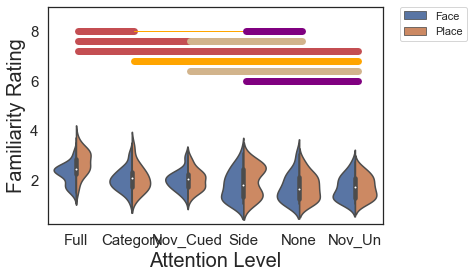

/sustain_2: Average Familiarity by Attention Level


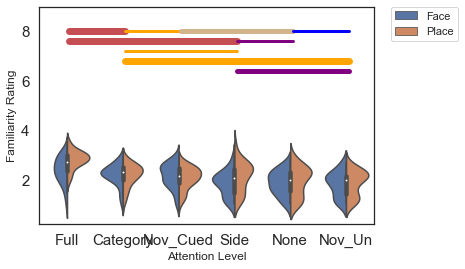

/variabl_1: Average Familiarity by Attention Level


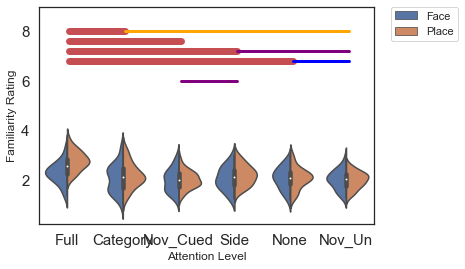

/variabl_2: Average Familiarity by Attention Level


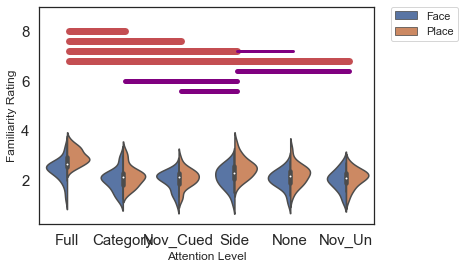

In [242]:
# PLOT PARAMS

stat_dict_full = {'/sustain_1':{}, '/sustain_2':{}, '/variabl_1':{}, '/variabl_2':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)


# for each experiment, for each test group, group and plot

for experiment in ['/sustain', '/variabl']:
    
    for group in [1,2]:
        
        label = experiment + '_' + str(group)
        
        d = data_original[(data_original['Experiment']==experiment)&(data_original['Group']==group)]
        
    
        # VIOLIN PLOT
        data = d.groupby(['UniqueID','Attention Level', 'Category'], as_index = False).mean()
        print(label + ': Average Familiarity by Attention Level')
        sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                     data = data, hue='Category', split=True,
                     order=cats)
        sb_plot.set(ylim=(.2, 9))
        ax1 = sb_plot.axes


        ### SIGNIFICANCE STARS FOR PLOTTING ###
        t_draw = {}

#         for c in data['Attention Level'].unique():
# #             if c in(['Nov_Cued','Nov_Un']) and label=='Experiment_2':

# #                 # if comparing novel images from exp2, eliminate participant 28 (all Place-cued as last cued category)
# #                 first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face') & (data['UniqueID']!=28)]['Familiarity Rating'])
# #                 second = list(data[(data['Attention Level']==c) & (data['Category']=='Place') & (data['UniqueID']!=28)]['Familiarity Rating'])

# #             else:
#             first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
#             second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])

#             t = scipy.stats.ttest_rel(first, second)

#             if t[1]<.001:
#                 t_draw[c] = '***'

#             elif t[1]<.01:
#                 t_draw[c] = '**'

#             elif t[1]<.05:
#                 t_draw[c] = '*'

#             elif t[1]<.0551:
#                 t_draw[c] = '+'


        ### SIGNIFICANCE BETWEEN VIOLINS FOR PLOTTING ###
        stat_dict = {}
        k = data.groupby(['UniqueID','Attention Level'],as_index=False).mean()

        for pair in list(itertools.combinations(cats, r=2)):
            t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                                k[k['Attention Level']==pair[1]]['Familiarity Rating'])
            stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

            # dictionary where every key is a pair categories with a difference that has p value less than .0551
            if t[1]<=.0551:
                stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}


        ### CREATE AND ADD SIGNIFICANCE LINES TO PLOT ###
        for relationship in  ['pos','neg']:

            plotted_cats = []
            to_be_plotted = []
            line_height = 0

            # FOR EACH CATEGORY
            for idx,c in enumerate(cats):

                x = sig_bars(c, cats, stat_dict, sign=relationship)
                # get all significance lines from this category to every other category

                for idx,line in enumerate(x):
                # for each line from this category to another category (starting with the nearest category)

                    if (line['categories'] not in plotted_cats) and (line!=np.nan) and (type(line['categories'])!=float):
                    # if there is a difference in the correct direction (pos/neg) and it has not been plotted yet

                        line['y'] = line['y'] + line_height
                        # assign the next available height to this line 
                        # (give its height a boost based on how many lines have been plotted already)

                        to_be_plotted.append(line)
                        # append this line to the list of lines to be plotted

                        plotted_cats.append(line['categories'])
                        # add this category pair to the list of category pairs that has been plotted

                        # CONTINUE THE CASCADE OF LINES
                        # now, start from the category we have just drawn a line to
                        # and loop through the rest of the categories from there

                        # first, give the line a new name so we can loop over new lines, without losing our first one
                        b = line

                        # as long as there is difference in the correct direction (pos/neg) 
                        # between the most recent category and the next one
                        while b['next']!= 0 :

                            # grab the first category for the line between them
                            first_cat = b['categories'][0]

                            # then get the line STARTING from the category we have just drawn a line to, to the NEXT category it differs from
                            b = sig_bars(b['next'], cats, stat_dict, sign=relationship)[0]

                            # if there is a difference in the correct direction (pos/neg) that has not been plotted yet
                            if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):

                                # adjust its height so it is the same height as the line that brought us here
                                b['y'] = b['y'] + line_height

                                # add this line to the lines we will plot
                                to_be_plotted.append(b)

                                # add this category pair to the list of pairs that's been plotted
                                plotted_cats.append(b['categories'])

                                # also add the pair of categories containing the original starting category and this ending category
                                # (so that doesn't get plotted redundantly)
                                plotted_cats.append((line['categories'][0], b['categories'][1]))

                                # AND add the relationship from the original starting category to this starting category
                                # (so that doesn't get plotted redundantly)
                                plotted_cats.append((first_cat, b['categories'][1]))

                        line_height = line_height - .4
                        # adjust height next lines will be drawn at

            # Plot the lines
            for each in to_be_plotted:

                if relationship == 'pos':
                    ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                        linewidth = each['width'], color = col[cats.index(each['categories'][0])])

                if relationship == 'neg':
                    ax1.axhline(each['y']-2, ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                        linewidth = each['width'], color = col[-cats.index(each['categories'][1])])

        # Plot the stars
        for stars in t_draw:
            ax1.text((cats.index(stars)), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')

        # save figure
        # plt.savefig(label+"_violin.pdf")

        # show figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

## Timecourse Plots

In [15]:

# Apply sliding window
window_length = 20

exp1_mean_window = apply_window(exp1, window_length)
exp2_mean_window = apply_window(exp2, window_length)

# prepare data for plotting
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
    
    # assign data to dictionary key
    plot_data[key] = group_melt
    
# plotting color key
palette = sb.color_palette("RdBu", 20)
# Cued category    -->  warm colors 
# Uncued category  -->  cool colors

## Sliding Window - Familiarity Over Time

### Sliding Window - Novel Images

exp1: Sliding Window - Novel Images Only


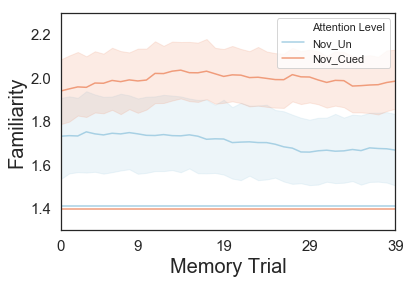

exp2: Sliding Window - Novel Images Only


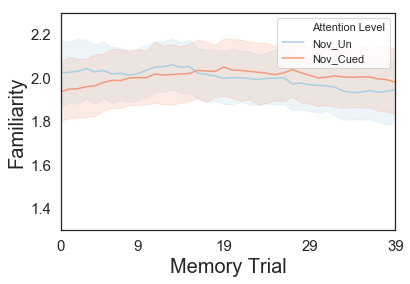

In [60]:
import scipy

sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(key + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    ax.set(xlim=(0, 39))
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    
    # add lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        # plt.axvline(x, .1, .3, color='red')
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"novel_time.pdf")
    plt.show()    
    

### Novel Image Difference Scores

slope = 0.002606553384591277
intercept = 0.23460738828051547
p_value = 7.438997285666216e-13

exp1


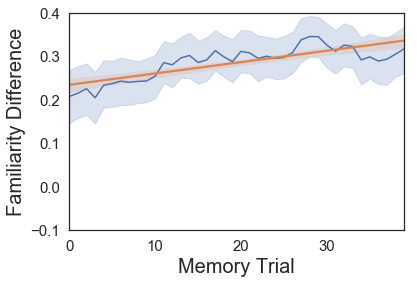

slope = 0.0038157803993496497
intercept = -0.06814893684438543
p_value = 1.1480295011379609e-35

exp2


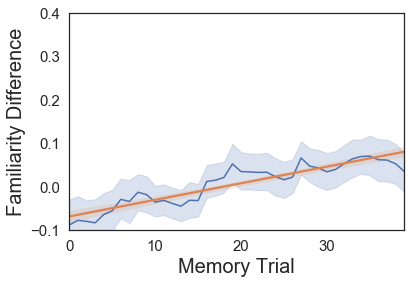

In [61]:
from sklearn.linear_model import LinearRegression

for exp in plot_data.keys():
    
    trial_avs = plot_data[exp].groupby(['Trial','Attention Level','Subject'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan
    
    for s in trial_avs['Subject'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            difference = first - second

            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['Subject']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
    ax.set(xlim=(0, 39))
    
    sb.regplot(x="Trial", y="Nov_Diffs", data=trial_avs, scatter=False)
    
    trial_av_grp = trial_avs.groupby(['Trial'], as_index=False).mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(trial_avs['Trial'], trial_avs['Nov_Diffs'])
    
    print('slope = ' + str(slope))
    print('intercept = ' + str(intercept))
    print('p_value = ' + str(p_value))
    print()
        
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    
    plt.savefig(exp+"_novel_diff.pdf")
    
    print(exp)
    plt.show()


### Uncued Category images


Experiment 1: Sliding Window - Uncued Category Images


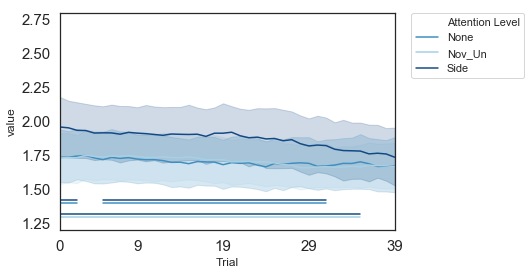

Experiment 2: Sliding Window - Uncued Category Images


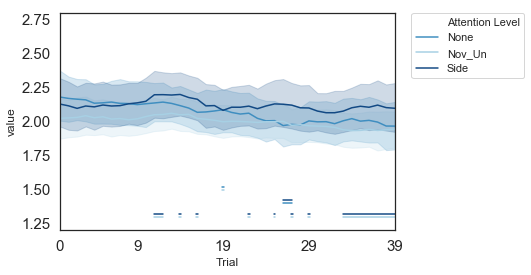

In [62]:
sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))

    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                        
        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','None'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        else:
            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
    
        else:
            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])

        
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"_uncued_categories.pdf")
    plt.show()
    

### Sliding Window - Images in Cued Category

Experiment_1: Sliding Window - Same Category Images - Faces


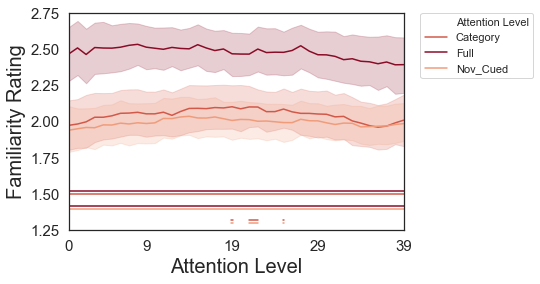

Experiment_2: Sliding Window - Same Category Images - Faces


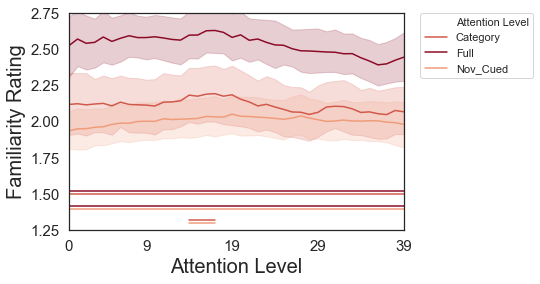

In [63]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
        
        
        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"cued_categories.pdf")
    
    plt.show()
    

In [64]:
# Apply sliding window
window_length = 20

exp1_nov_mean_window = apply_window(exp1_Novel, window_length)
exp2_nov_mean_window = apply_window(exp2_Novel, window_length)

# prepare data for plotting
plot_data_nov={}

for data,key in zip([exp1_nov_mean_window, exp2_nov_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Novel','Side'])
    
    # assign data to dictionary key
    plot_data_nov[key] = group_melt
    
# plotting color key
palette = sb.color_palette("RdBu", 20)
# Cued category    -->  warm colors 
# Uncued category  -->  cool colors

In [65]:
plot_data_nov['exp1']['Attention Level'].unique()

array(['Category', 'Full', 'None', 'Novel', 'Side'], dtype=object)

In [ ]:
for key,label in zip(plot_data_nov.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data_nov[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Novel', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Novel'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Novel') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
        
        
        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Novel','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"cued_categories.pdf")
    
    plt.show()
    

In [ ]:
sb.set_style("white")

for key,label in zip(plot_data_nov.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data_nov[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Novel'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))

    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Novel'])]
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Novel'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Novel') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                        
        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','None'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        else:
            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Novel','None'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Novel') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
    
        else:
            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])

        
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"_uncued_categories.pdf")
    plt.show()

### Images in Cued Location

Experiment_1: Sliding Window - Same Category Images - Faces


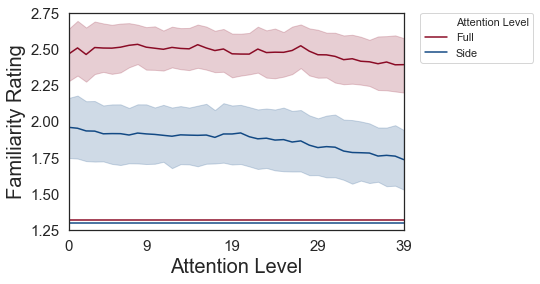

Experiment_2: Sliding Window - Same Category Images - Faces


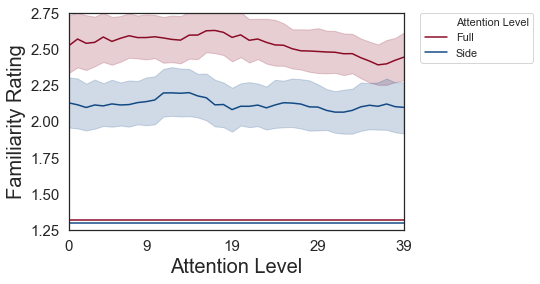

In [41]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"_cued_location.pdf")
    plt.show()
    

### Images in Uncued Location

Experiment_1: Sliding Window - Same Category Images - Faces


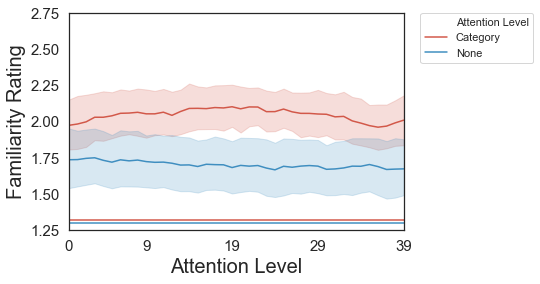

Experiment_2: Sliding Window - Same Category Images - Faces


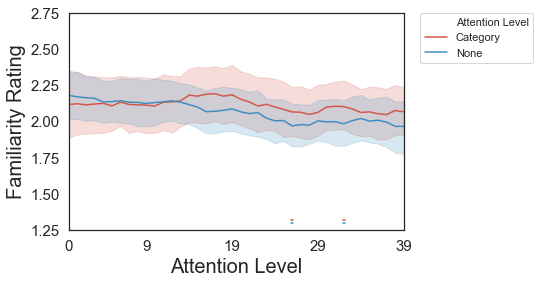

In [42]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
               
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.savefig(label+"_uncued_location.pdf")
    
    plt.show()
    